In [48]:
import math
import torch
import torch.nn as nn

from fairseq.models.bart import BARTModel
from utils import read_lines

In [71]:
finetuned_bart = BARTModel.from_pretrained('/home/ml/cadencao/fairseq/checkpoints/xsum_cmlm_bos_ent',
                                           checkpoint_file='checkpoint_best.pt',
                                           data_name_or_path='/home/ml/cadencao/XSum/fairseq_files/xsum-bin')

In [72]:
finetuned_bart.cuda()
finetuned_bart.eval()
finetuned_bart.half()
print('- fine-tuned bart model loaded.')

- fine-tuned bart model loaded.


In [73]:
bart = BARTModel.from_pretrained('/home/ml/cadencao/Downloads/BART_models/bart.large',
                                 checkpoint_file='model.pt',
                                 data_name_or_path='/home/ml/cadencao/Downloads/BART_models/bart.large')

In [74]:
bart.cuda()
bart.eval()
bart.half()
print('- bart model loaded.')

- bart model loaded.


In [75]:
encode_func = bart.encode
decode_func = bart.decode

#### Read XSum

In [76]:
document_path = '/home/ml/cadencao/XSum/fairseq_files/test.source'
target_path = '/home/ml/cadencao/XSum/fairseq_files/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Generate Summary

In [77]:
from fairseq.data.data_utils import collate_tokens

In [78]:
def tokenize(src_input, verbose=False):
    src_inputs = [src_input]  # list of input string
    src_tokens = collate_tokens([encode_func(i) for i in src_inputs], pad_idx=1, left_pad=True)
    src_tokens = src_tokens.cuda()
    src_lengths = torch.sum(src_tokens != 1, dim=1)
    
    if verbose:
        print('- src tokens: {};\n- src lengths: {}'.format(src_tokens.shape, src_lengths.shape))
    return src_tokens, src_lengths

In [79]:
def tokenize_with_mask(input_sentence):
    bpe_code = bart.bpe.encode(input_sentence)  # <mask>: 1279 27932 29
    input_ids = bart.task.source_dictionary.encode_line('<s> ' + bpe_code.replace('1279 27932 29', '<mask>'), 
                                                        append_eos=True).long()
    input_ids = input_ids.unsqueeze(0).cuda()
    src_lengths = torch.sum(input_ids != 1, dim=1)
    return input_ids, src_lengths

In [80]:
def generate_sequence(decoder, encoder_out, batch_size=1, tgt_tokens=None, min_decode_step=1, max_decode_step=100, pad_id=1, eos_id=2, verbose=True):
    init_input = torch.tensor([[2, 0]] * batch_size, dtype=torch.long).cuda()
    softmax = nn.Softmax(dim=1)
    token_probs, tokens = [], []

    for step in range(max_decode_step):
        decoder_outputs = decoder(init_input, encoder_out, features_only=False)
        logits = decoder_outputs[0][:, -1, :]  # [batch_size, vocab]
        
        if step + 1 < min_decode_step:
            logits[:, eos_id] = -math.inf
        logits[:, pad_id], logits[:, 0] = -math.inf, -math.inf  # never select pad, start token

        probs = softmax(logits)
        assert logits.shape == probs.shape
        attn = decoder_outputs[1]['attn'][0]  # [batch_size, prev_token_len, src_token_len]
        assert logits.dim() == 2 and attn.dim() == 3

        if tgt_tokens is not None:
            selected_token = tgt_tokens[step].unsqueeze(0)
        else:
            value, indices = torch.topk(probs, 5, dim=1)
            selected_token = indices[:, 0]

        init_input = torch.cat([init_input, selected_token.unsqueeze(1)], dim=-1)
        token, prob = decode_func(selected_token), probs.squeeze()[selected_token.item()].item()
        
        if selected_token.item() == eos_id:
            break
        elif verbose:
            print("- {:02d}: {} ({:.2f})".format(step, token, prob), end='\n')

        token_probs.append(prob)
        tokens.append(token)

    return init_input, tokens, token_probs

In [81]:
def get_cmlm_probability(bart_model, masked_sentence, entity, verbose=False):
    masked_input, masked_lengths = tokenize(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input,
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=bart_model.encode(entity)[1:].cuda(),
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    assert decode_func(masked_output_ids[0]) == entity
    assert ''.join(masked_tokens) == entity
    
    prob = 1.0
    for i in range(3, len(masked_token_probs)):
        prob *= masked_token_probs[i]
    return prob

In [82]:
def get_prior_probability(bart_model, sentence, masked_sentence, position, entity, verbose=False):
    masked_input, masked_lengths = tokenize_with_mask(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input,
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=bart_model.encode(sentence)[1:].cuda(),
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    assert decode_func(masked_output_ids[0]) == sentence, '{}; {}'.format(decode_func(masked_output_ids[0]), sentence)

    return get_probability(position, masked_tokens, masked_token_probs, entity)

In [83]:
def cmlm_generate(bart_model, masked_sentence, verbose=False):
    masked_input, masked_lengths = tokenize(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input, 
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=None,
                                       verbose=verbose)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    
    return decode_func(masked_output_ids[0])

In [84]:
def prior_generate(bart_model, masked_sentence):
    masked_input, masked_lengths = tokenize_with_mask(masked_sentence)
    masked_outputs = generate_sequence(bart_model.model.decoder,
                                       bart_model.model.encoder(masked_input, 
                                                                src_lengths=masked_lengths),
                                       tgt_tokens=None,
                                       verbose=False)
    masked_output_ids, masked_tokens, masked_token_probs = masked_outputs
    
    return decode_func(masked_output_ids[0])

#### Get Conditional Probability

In [85]:
import spacy

nlp = spacy.load('en')

In [86]:
INDEX = 9444

In [87]:
source = xsum_source[INDEX]
target = "Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition."
print(target)

ent_parts = nlp(target).to_json()['ents']
print(ent_parts, end='\n\n')

for e in ent_parts:
    entity = target[e['start']: e['end']]
    
    with torch.no_grad():
        masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
        prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)
        print(target[0: e['start']] + '<mask>' + target[e['end']:])
#         print('- prior: {}'.format(prior_generate(bart, masked_hypothesis)))

        masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
        masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
        posterior = get_cmlm_probability(finetuned_bart,
                                         masked_hypothesis,
                                         '<s> ' + entity, 
                                         verbose=False)
        print(target[0: e['start']] + '###' + target[e['end']:])
        print('- posterior: {}'.format(cmlm_generate(finetuned_bart, masked_hypothesis, verbose=False)))

        print('- entity: {}'.format(entity))
        print('- prior: {}'.format(prior))
        print('- posterior: {}'.format(posterior))
        print('- ratio: {:.3f} / {:.3f} = {:.3f}'.format(posterior, prior, posterior / (prior + 1e-5)))
        print()

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
[{'start': 35, 'end': 39, 'label': 'ORG'}, {'start': 75, 'end': 82, 'label': 'ORG'}]

Twin-to-twin transfusion syndrome (<mask>) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
Twin-to-twin transfusion syndrome (###) is being tracked by a hospital in Cardiff in a bid to save the lives of babies born with the condition.
- posterior: <s> TTTS
- entity: TTTS
- prior: 0.0003767434973269701
- posterior: 0.8750224113464355
- ratio: 0.875 / 0.000 = 2262.539

Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in <mask> in a bid to save the lives of babies born with the condition.
Twin-to-twin transfusion syndrome (TTTS) is being tracked by a hospital in ### in a bid to save the lives of babies born with the condition.
- posterior: <s> London
- entity: Cardiff
- prior: 0.00116

#### Read Annotated Data

In [88]:
import json

from tqdm import tqdm

In [89]:
data = json.load(open('annotated.json', 'r'))
print(len(data))

95


In [90]:
data[55]

{'id': 10380,
 'pred': 'A Palestinian woman who was seriously injured in a firebombing in the occupied West Bank that killed her toddler son and her husband has died in an Israeli hospital, her family says.',
 'ents': [{'start': 2, 'end': 13, 'label': 'NORP'},
  {'start': 79, 'end': 88, 'label': 'GPE'},
  {'start': 148, 'end': 155, 'label': 'NORP'}],
 'hallucination ents': [],
 'hallucinations': ['in a firebombing',
  'in an Israeli hospital',
  'her family says'],
 'correctness': []}

In [91]:
prior_posterior = []

for INDEX in tqdm(range(len(data))):
    source = xsum_source[data[INDEX]['id']]
    
    for i, e in enumerate(data[INDEX]['ents']):
        target = data[INDEX]['pred']
        entity = target[e['start']: e['end']]
        
        with torch.no_grad():
            masked_hypothesis = target[0: e['start']] + '<mask>' + target[e['end']:]
            prior = get_prior_probability(bart, target, masked_hypothesis, (e['start'], e['end']), entity)

            masked_hypothesis = target[0: e['start']] + '###' + target[e['end']:]
            masked_hypothesis = '<s> ' + masked_hypothesis + ' <\s> ' + source
            posterior = get_cmlm_probability(finetuned_bart,
                                             masked_hypothesis,
                                             '<s> ' + entity, 
                                             verbose=False)
#             print(target[0: e['start']] + '###' + target[e['end']:])
#             print(cmlm_generate(finetuned_bart, masked_hypothesis, verbose=False))

            assert len(data[INDEX]['hallucination ents']) == len(data[INDEX]['correctness']), 'INDEX: {}'.format(INDEX)
            if i not in data[INDEX]['hallucination ents']:
                label = 0
            else:
                if data[INDEX]['correctness'][data[INDEX]['hallucination ents'].index(i)]:
                    label = 1
                else:
                    label = 2
                    assert not data[INDEX]['correctness'][data[INDEX]['hallucination ents'].index(i)]

            prior_posterior.append({'id': data[INDEX]['id'], 
                                    'prior': prior, 
                                    'posterior': posterior, 
                                    'entity': entity, 
                                    'entity pos': e, 
                                    'label': label})

100%|██████████| 95/95 [04:28<00:00,  2.82s/it]


In [92]:
print(len(prior_posterior))
print(prior_posterior[0])

326
{'id': 8805, 'prior': 0.019102683108940255, 'posterior': 0.2142894584685564, 'entity': 'more than 100', 'entity pos': {'start': 62, 'end': 75, 'label': 'CARDINAL'}, 'label': 2}


In [93]:
# import json

In [94]:
# with open('prior_posterior.json', 'w') as fout:
#     json.dump(prior_posterior , fout)

#### Draw Diagram

In [95]:
# prior_posterior = json.load(open('prior_posterior.json', 'r'))
# print(len(prior_posterior))

In [96]:
%matplotlib inline

import matplotlib.pyplot as plt

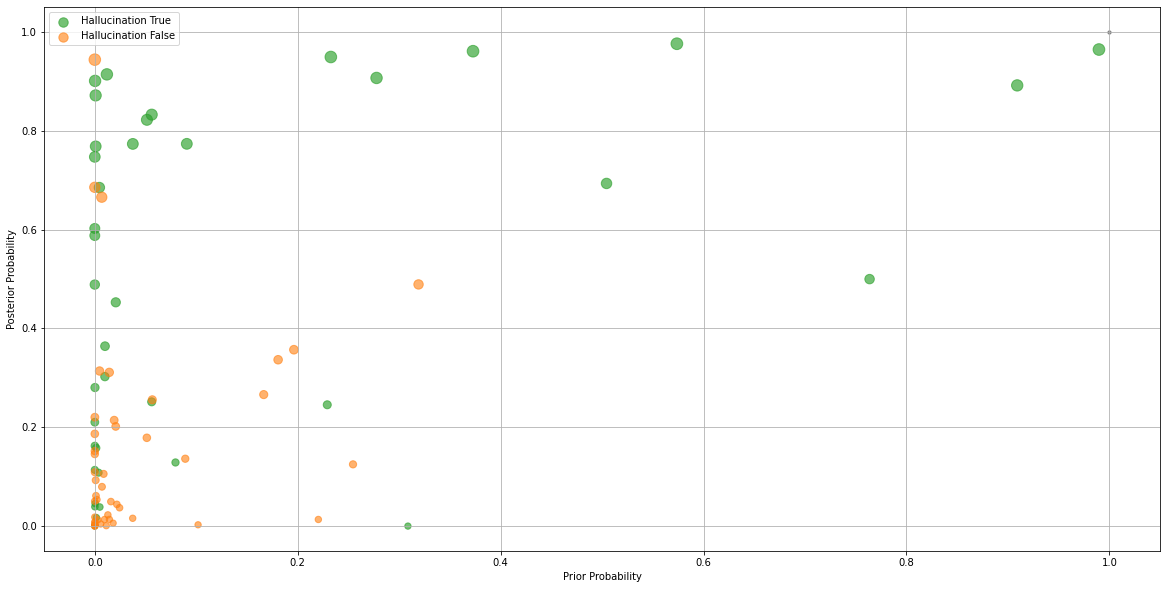

In [97]:
fig, ax = plt.subplots(figsize=(20.0, 10.0))
colors = ['tab:blue', 'tab:orange', 'tab:green']

no_hallucinated = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0]
hallucinated_true = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1]
hallucinated_false = [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2]

# ax.scatter([i[0] for i in no_hallucinated], 
#            [i[1] for i in no_hallucinated], c='tab:blue', s=[i[1]*100 + 40 for i in no_hallucinated], label='Non-hallucination', alpha=0.7)

ax.scatter([i[0] for i in hallucinated_true], 
           [i[1] for i in hallucinated_true], c='tab:green', s=[i[1]*100 + 40 for i in hallucinated_true], label='Hallucination True', alpha=0.65)
ax.scatter([i[0] for i in hallucinated_false], 
           [i[1] for i in hallucinated_false], c='tab:orange', s=[i[1]*100 + 40 for i in hallucinated_false], label='Hallucination False', alpha=0.6)

ax.scatter([1.0], [1.0], c='tab:gray', s=10)

ax.set_xlabel('Prior Probability')
ax.set_ylabel('Posterior Probability')
ax.legend()
ax.grid(True)

plt.savefig('foo.png')
plt.show()

In [98]:
for p in prior_posterior:
    if p['label'] == 2 and p['posterior'] > 0.5:
        print(p)

{'id': 2427, 'prior': 1.8477439880371094e-05, 'posterior': 0.685546875, 'entity': 'Dublin', 'entity pos': {'start': 123, 'end': 129, 'label': 'GPE'}, 'label': 2}
{'id': 8770, 'prior': 4.287343472242355e-06, 'posterior': 0.94384765625, 'entity': 'Everton', 'entity pos': {'start': 0, 'end': 7, 'label': 'GPE'}, 'label': 2}
{'id': 5620, 'prior': 0.00687408447265625, 'posterior': 0.66552734375, 'entity': 'second', 'entity pos': {'start': 2, 'end': 8, 'label': 'ORDINAL'}, 'label': 2}


#### Classification

In [99]:
prior_posterior_dict = {}

for p in prior_posterior:
    if p['id'] not in prior_posterior_dict:
        prior_posterior_dict[p['id']] = []
    prior_posterior_dict[p['id']].append(p)

In [100]:
prior_posterior[0]

{'id': 8805,
 'prior': 0.019102683108940255,
 'posterior': 0.2142894584685564,
 'entity': 'more than 100',
 'entity pos': {'start': 62, 'end': 75, 'label': 'CARDINAL'},
 'label': 2}

In [101]:
true_label = []
ent_pred_label = []
prob_pred_label = []

for p in prior_posterior:
    source = xsum_source[p['id']]
    
    if p['entity'].lower() in source.lower():
        ent_pred_label.append(0)
    else:
        ent_pred_label.append(1)
        
    if p['label'] == 0 or p['label'] == 1:
        true_label.append(0)
    else:
        true_label.append(1)

    if p['posterior'] > 0.1 or p['prior'] > 0.2:
        prob_pred_label.append(0)
    else:
        prob_pred_label.append(1)

In [102]:
from sklearn.metrics import classification_report

In [103]:
print(classification_report(true_label, ent_pred_label, target_names=['Non-hallucination', 'Hallucination']))

                   precision    recall  f1-score   support

Non-hallucination       0.98      0.69      0.81       280
    Hallucination       0.33      0.93      0.49        46

         accuracy                           0.72       326
        macro avg       0.66      0.81      0.65       326
     weighted avg       0.89      0.72      0.77       326



In [104]:
print(classification_report(true_label, prob_pred_label, target_names=['Non-hallucination', 'Hallucination']))

                   precision    recall  f1-score   support

Non-hallucination       0.92      0.91      0.92       280
    Hallucination       0.49      0.52      0.51        46

         accuracy                           0.86       326
        macro avg       0.71      0.72      0.71       326
     weighted avg       0.86      0.86      0.86       326



In [105]:
len(data)

95

In [106]:
data[0]

{'id': 8805,
 'pred': 'A biscuit maker has gone into administration with the loss of more than 100 jobs after the UK voted to leave the European Union.',
 'ents': [{'start': 62, 'end': 75, 'label': 'CARDINAL'},
  {'start': 91, 'end': 93, 'label': 'GPE'},
  {'start': 109, 'end': 127, 'label': 'ORG'}],
 'hallucination ents': [0],
 'hallucinations': ['more than 100 jobs'],
 'correctness': [False]}

In [107]:
total_ents = 0

for d in data:
    total_ents += len(d['hallucination ents'])

In [108]:
total_ents

87

In [109]:
89 / 326

0.27300613496932513

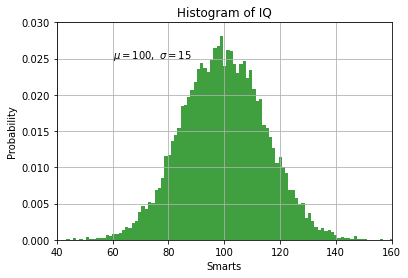

In [110]:
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

mu, sigma = 100, 15
x = mu + sigma * np.random.randn(10000)

# the histogram of the data
n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.75)


plt.xlabel('Smarts')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
plt.xlim(40, 160)
plt.ylim(0, 0.03)
plt.grid(True)
plt.show()

In [111]:
source = xsum_source[8770]

In [112]:
source

'The 19-year-old will now be eligible to play against Barnsley in the Football League Trophy final on Sunday. Kenny, who joined up with the England Under-20 squad over Easter, has so far made 13 appearances for the U\'s. "He has done really well for us and is enjoying his football," said Oxford head coach Michael Appleton. "He is highly thought of at Goodison Park and has a big future."'